## Fake news detection with sentiment analysis

In this project, I analyze articles with FastText and Pytorch.

The goal is to create a system, which will be able to classify a specific article as a fake news or a legitimite one.

In [1]:
from transformers import ElectraTokenizer, ElectraModel
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import AdamW
import transformers
import io
from sklearn.metrics import confusion_matrix

In [2]:
import gensim.models.wrappers.fasttext
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data preproocessing

First, we need to get our dataset. I choose a dataset from Kaggle. You can find it on https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

In [3]:
import pandas as pd
import numpy as np

In [4]:
df =  pd.read_csv("data.csv")

In [5]:
df.head()

,Unnamed: 0,title,content,label
0,0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


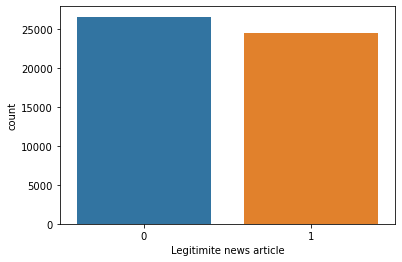

In [30]:
sns.countplot(df.label)
plt.xlabel('Legitimite news article');

We can see that our dataset is balanced. That means that we can continue and vectorize the content of the articles.

## Text vectorization

For the vectorization, we are going to use a pretrained FastText model. You can get it from https://fasttext.cc/docs/en/english-vectors.html

First, we load up a list of english stopwords. I got mine from https://www.ranks.nl/stopwords 


In [7]:
with open("stopwords.txt") as f:
    stopwords = f.read().splitlines()

In [8]:
ft_model = gensim.models.KeyedVectors.load_word2vec_format('model/crawl-300d-2M-subword.vec', binary=False, encoding='utf8')

In [9]:
def get_vector_representation(title, content):
    tokens=nltk.word_tokenize(re.sub(r'\W', ' ', str(title)+". "+str(content)))
    tokens=[token for token in tokens if token not in stopwords and token in ft_model]

    return np.mean([ft_model[token]for token in tokens[:20]],axis=0)

We represent each article by a specific vector. We combine the title and the content of the article and then tokenize them. We select the first 20 vectors, get their representations from the FastText model. After that, we just average them out and we have a good representation of the text.

In [10]:
df["vector_representation"]=df.apply(lambda x:get_vector_representation(x["title"],x["content"]),axis=1)

In [11]:
class FakeNewsDataset(Dataset):
  def __init__(self, titles,content, labels,vectors):
    self.titles = titles
    self.content = content
    self.labels = labels
    self.vectors=vectors

  def __len__(self):
    return len(self.titles)


  def __getitem__(self, id):
    title = str(self.titles[id])
    content = str(self.content[id])
    label=self.labels[id]
    vector=self.vectors[id]

    return {
      'text': title+content,
      'vector': vector,
      'labels':label
    }

In [12]:
RANDOM_SEED=2

Creating the training, testing and evaluation dataset

In [13]:
df_train, df_test = train_test_split(
  df,
  test_size=0.1, random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5, random_state=RANDOM_SEED
)

In [14]:
def get_loader(df, batch_size):
  ds = FakeNewsDataset(
    titles=df.title.to_numpy(),
    content=df.content.to_numpy(),
    labels=df.label.to_numpy(),
    vectors=df.vector_representation.to_numpy()
  )
  return DataLoader(
    ds,
    batch_size=batch_size
  )

Get a loader for each dataset with batch size equal to 16

In [15]:
BATCH_SIZE = 16
train_data_loader = get_loader(df_train, BATCH_SIZE)
val_data_loader = get_loader(df_val, BATCH_SIZE)
test_data_loader = get_loader(df_test, BATCH_SIZE)

Each vector has 300 dimensions and we have two classes, therefore the classifier needs to have a linear transformation from 300 dimensions to 2

In [16]:
class SentimentClassifier(nn.Module):
  def __init__(self, class_size):
    super(SentimentClassifier, self).__init__()
    self.out = nn.Linear(300, class_size)

  def forward(self, vector):
    return self.out(vector)

In [17]:
model=SentimentClassifier(2)

## Training the classifier

In [18]:
EPOCHS=10

optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss()

In [19]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    labels=d["labels"]
    _,preds = torch.max(model(d["vector"]), dim=1)
    loss = loss_fn(model(d["vector"]), labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    vector = d["vector"]
    labels = d["labels"]

    _,preds = torch.max(model(vector), dim=1)
    
    loss = loss_fn(model(vector), labels)
    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
%%time
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    scheduler,
    len(df_train)
  )
  print(f'Training: loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    len(df_val)
  )
  print(f'Evaluation: loss {val_loss} accuracy {val_acc}')
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model.bin')
    best_accuracy = val_acc

Epoch 1/10
Training: loss 0.6230295422712521 accuracy 0.8048103407143942
Evaluation: loss 0.5651586590716557 accuracy 0.9309133489461359
Epoch 2/10
Training: loss 0.5259600599489636 accuracy 0.947667483571537
Evaluation: loss 0.4885043474087804 accuracy 0.9465261514441843
Epoch 3/10
Training: loss 0.4621200038173147 accuracy 0.9544340584267713
Evaluation: loss 0.4352536854906852 accuracy 0.9512099921935987
Epoch 4/10
Training: loss 0.4163855241351786 accuracy 0.9561473898805005
Evaluation: loss 0.3964043585410029 accuracy 0.9504293520686963
Epoch 5/10
Training: loss 0.38268225207811096 accuracy 0.9566462078986748
Evaluation: loss 0.36759684109909935 accuracy 0.9523809523809523
Epoch 6/10
Training: loss 0.35771286092558974 accuracy 0.9568847730378017
Evaluation: loss 0.34641453901433056 accuracy 0.953551912568306
Epoch 7/10
Training: loss 0.33955273837740435 accuracy 0.9571450259168492
Evaluation: loss 0.3312977321954988 accuracy 0.953551912568306
Epoch 8/10
Training: loss 0.32690904823

## Evaluation

In [22]:
test_acc, test_loss = eval_model(
    model,
    test_data_loader,
    loss_fn,
    len(df_test)
  )

In [23]:
test_acc

tensor(0.9594, dtype=torch.float64)

We can see that our test dataset has the same accuracy as the training one. That means that our model is not oversatured and generalizes well. We can continue with the evaluation

In [24]:
model(torch.from_numpy(get_vector_representation("In fresh blow to Trump, U.S. court rejects Pennsylvania election case","A federal appeals court on Friday rejected an attempt by U.S. President Donald Trump’s campaign to block President-elect Joe Biden from being declared the winner of Pennsylvania, dealing another significant setback to Trump’s bid to overturn the Nov. 3 election.“Free, fair elections are the lifeblood of our democracy. Charges of unfairness are serious. But calling an election unfair does not make it so,” wrote Stephanos Bibas on behalf of a three-judge panel.“Charges require specific allegations and then proof. We have neither here,” wrote Bibas, who was nominated by Trump.The Trump campaign and its supporters have tried and failed to convince judges of election irregularities in Michigan, Georgia, Arizona and Nevada, all critical to Biden’s victory.“Voters, not lawyers, choose the President. Ballots, not briefs, decide elections,” said the appeals court opinion.“On to SCOTUS!” wrote Jenna Ellis, a Trump campaign attorney, on Twitter after the ruling, referring to a planned appeal to the U.S. Supreme Court. “The activist judicial machinery in Pennsylvania continues to cover up the allegations of massive fraud.”Pennsylvania certified Biden, who won the state by 80,000 votes, as its winner this week. Under Pennsylvania law, the candidate who wins the popular vote in the state gets all of the state’s 20 electoral votes.")))

tensor([-0.6774,  0.6346], grad_fn=<AddBackward0>)

Here we tried putting a legitimite article into the model. You can see that our model correctly assumed that this article is not fake news

In [25]:
model(torch.from_numpy(get_vector_representation("You Can Smell Hillary's Fear","Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. The word â€śunprecedentedâ€ť has been thrown around so often this election that it ought to be retired. But itâ€™s still unprecedented for the nominee of a major political party to go war with the FBI. But thatâ€™s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillaryâ€™s opponent in this election. The FBI is under attack by everyone from Obama to CNN. Hillary people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldnt be too surprising if the Clintons or their allies were to start running attack ads against the FBI. The FBI leadership is being warned that the entire left-wing establishment will form a lynch mob if they continue going after Hillary. And the FBI credibility is being attacked by the media and the Democrats to preemptively head off")))

tensor([ 0.4043, -0.4288], grad_fn=<AddBackward0>)

However, if we put a fake news into the model, model correctly evalues it as fake

In [26]:
result_table=[[0]*2]*2

def get_results(model,data_loader):
    model = model.eval()
    correct=[]
    predicted=[]
    with torch.no_grad():
        for d in data_loader:
            vector = d["vector"]
            labels = d["labels"]

            _,preds = torch.max(model(vector), dim=1)
            correct+=labels
            predicted+=preds
    
    return [correct,predicted]

In [27]:
matrix_data=get_results(model,train_data_loader)

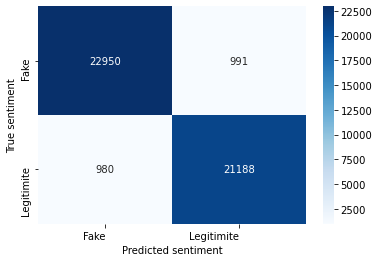

In [32]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(matrix_data[0], matrix_data[1])
df_cm = pd.DataFrame(cm, index=["Fake","Legitimite"], columns=["Fake","Legitimite"])
show_confusion_matrix(df_cm)

## Conclusion

In this matrix, we are able to see that our model evalues most of the articles correctly. However, about 4 percent were incorrect and split equally between false positives and true negatives.

I think that if we want to create a more precise classifier, we would need to use a different model, which will take into account the articles as a whole. Because when there is a misinformation somewhere in the middle of the text, our model won't be able to find it. I could suggest using Electra or BERT.

However, I still believe a 96 percent accuracy is impressive and it is a lot more than I expected when I started the project.